# Accuracy Evaluation of Generated InfoLossQA's

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import json
import os
from pprint import pprint
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from label_studio_sdk import Client, parse_config

from info_loss.statistics import load_data, load_data_aggregated, qa_stats
from info_loss import iaa
import utils

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
def edit2labelstudio(edit):
    highlights = []

    highlight_id = 0
    for start, end in edit["input_idx"]:
        x = {
            "id": f"{highlight_id}",
            "from_name": "source_label",
            "to_name": "source",
            "type": "labels",
            "value": {
                "start": start,
                "end": end,
                "score": 1,
                "text": edit["source"][start:end],
                "labels": [edit["category"]],
            },
        }
        highlights.append(x)
        highlight_id += 1
    for start, end in edit["output_idx"]:
        x = {
            "id": f"{highlight_id}",
            "from_name": "target_label",
            "to_name": "target",
            "type": "labels",
            "value": {
                "start": start,
                "end": end,
                "score": 1,
                "text": edit["target"][start:end],
                "labels": [edit["category"]],
            },
        }
        highlights.append(x)
        highlight_id += 1

    task = {
        "data": {
            "doc_id": edit["doc_id"],
            "edit_id": edit["id"],
            "source": edit["source"],
            "target": edit["target"],
            "question": edit["annotation"]["question"],
            "answer": edit["annotation"]["answer"],
        },
        "predictions": [
            {
                "model_version": "info_loss_model",
                "score": 1,
                "result": highlights,
            }
        ],
    }

    return task

In [5]:
annotations_manual = load_data_aggregated(
    annotators=[
        ("karim", "../data/raw/annotations/annotations-karim/"),
        ("keziah", "../data/raw/annotations/annotations-keziah/"),
        ("kathryn", "../data/raw/annotations/annotations-kathryn/"),
    ]
)

INCLUDE_DOC_IDS = set(
    doc_id for doc_id, doc in annotations_manual.items() if len(doc["annotations"]) >= 2
)
INCLUDE_SECTIONS = {
    "Background",
    "Methods",
    "Results",
    "Conclusion",
    "n/a (Unsectioned)",
}
print(f"Completed docs: {len(INCLUDE_DOC_IDS)}")


def load_predictions(model_path, model_name):
    preds = load_data(model_path, hash_edit_ids=True)
    qas = []
    for doc in preds:
        for qa in doc["edits"]:
            qa["doc_id"] = doc["id"]
            qa["primary_section"] = qa_stats(doc, qa)["primary_section"]
            qa["model"] = model_name
            qa["source"] = doc["source"]
            qa["target"] = doc["target"]
            # If qa does not have this property, will add a empty list, so that filter below
            # works for models without any prediction errors.
            qa["prediction_errors"] = qa.get("prediction_errors", [])
            qas.append(qa)

    df = pd.DataFrame(qas)
    df = df[
        df["doc_id"].isin(INCLUDE_DOC_IDS)
        & df["primary_section"].isin(INCLUDE_SECTIONS)
        & (df["prediction_errors"].apply(len) == 0)
    ]
    if "output_idx" not in df.columns:
        df["output_idx"] = ""
    df["input_idx"] = df["input_idx"].fillna("")
    df["output_idx"] = df["output_idx"].fillna("")
    return df


dfs_models = [
    load_predictions(
        "../output/gpt-4-0613-one-shot/predictions.json", "gpt-4-0613-one-shot"
    ),
    load_predictions("../output/gpt-4-0613-nli/predictions.json", "gpt-4-0613-nli"),
    load_predictions(
        "../output/llama2-70b-chat-one-shot/predictions.json",
        "llama2-70b-chat-one-shot",
    ),
    load_predictions(
        "../output/mistral-7b-instruct-one-shot/predictions.json",
        "mistral-7b-instruct-one-shot",
    ),
]

df_all_predictions = pd.concat(dfs_models)

Completed docs: 104


Get a new batch for annotation. Shuffle documents so that models come in random order, but sort by document id so that we benefit from batching if document occurs more than once in a batch. Pass exclude_ids to exclude certain documents from sampling.

In [6]:
def get_batch(df_models, n_per_model, exclude_ids=None, random_state=42):
    edits = []
    for df in df_models:
        if exclude_ids:
            df = df[~df["id"].isin(exclude_ids)]
        remain, edit = train_test_split(
            df,
            test_size=n_per_model,
            stratify=df["primary_section"],
            random_state=random_state,
        )
        edits.append(edit)
    batch = pd.concat(edits)
    batch = batch.sample(len(batch), random_state=random_state)  # shuffle
    batch = batch.sort_values(
        "doc_id"
    )  # sort by doc_id so that if we have twice the same doc in a batch, it comes right after another
    tasks = batch.apply(edit2labelstudio, axis=1).tolist()
    return tasks


def get_completed_ids(batches):
    ids = []
    for f in batches:
        with open(f) as fin:
            tasks = json.load(fin)
            for task in tasks:
                ids.append(task["data"]["edit_id"])
    return ids

In [7]:
# Assing a new batch, taking into account already assigned tasks.
# exclude_ids = get_completed_ids(
#     [
#         "../data/processed/eval-accuracy-tasks/batch1.json",
#         "../data/processed/eval-accuracy-tasks/batch2.json",
#         "../data/processed/eval-accuracy-tasks/batch3.json",
#         "../data/processed/eval-accuracy-tasks/batch4.json",
#         "../data/processed/eval-accuracy-tasks/batch5.json",
#         "../data/processed/eval-accuracy-tasks/batch6.json",
#         "../data/processed/eval-accuracy-tasks/batch7.json",
#     ]
# )
# tasks = get_batch(dfs_models, n_per_model=20, exclude_ids=exclude_ids, random_state=42)
# with open('../data/processed/eval-accuracy-tasks/batch8.json', 'w') as fout:
#     json.dump(tasks, fout)

In [8]:
# ls = Client(
#     url="https://ut-compling-label-studio-ts-info-loss.hf.space/",
#     api_key=os.environ["LABEL_STUDIO_API_KEY"],
# )

# utils.labelstudio_import(
#     ls,
#     config="../config/label-studio-accuracy.xml",
#     tasks="../data/processed/eval-accuracy-tasks/batch8.json",
#     title="Info Loss | Keziah | Batch 8",
# )
# utils.labelstudio_import(
#     ls,
#     config="../config/label-studio-accuracy.xml",
#     tasks="../data/processed/eval-accuracy-tasks/batch8.json",
#     title="Info Loss | Kathryn | Batch 8",
# )

## Calculate stats of assigned batches

In [9]:
assigned = [
    "../data/processed/eval-accuracy-tasks/batch1.json",
    "../data/processed/eval-accuracy-tasks/batch2.json",
    "../data/processed/eval-accuracy-tasks/batch3.json",
    "../data/processed/eval-accuracy-tasks/batch4.json",
    "../data/processed/eval-accuracy-tasks/batch5.json",
    "../data/processed/eval-accuracy-tasks/batch6.json",
    "../data/processed/eval-accuracy-tasks/batch7.json",
    "../data/processed/eval-accuracy-tasks/batch8.json",
]
assigned_tasks = []
for f in assigned:
    x = pd.read_json(f)
    x = pd.json_normalize(x["data"])
    x["batch"] = Path(f).stem
    assigned_tasks.append(x)
assigned_tasks = pd.concat(assigned_tasks)
assigned_tasks = assigned_tasks.set_index("edit_id")

# there was a bug in the sampling logic which caused duplicates in batch 5 and 6.
assigned_tasks = assigned_tasks[~assigned_tasks.index.duplicated()]

assigned_tasks = pd.merge(
    assigned_tasks,
    df_all_predictions.set_index("id")[["model", "primary_section"]],
    left_index=True,
    right_index=True,
)

In [10]:
pd.concat(
    [
        assigned_tasks.groupby("model").size().rename("Samples"),
        assigned_tasks.groupby("model")["primary_section"]
        .value_counts(normalize=True)
        .unstack(),
    ],
    axis=1,
)

,Samples,Background,Conclusion,Methods,Results,n/a (Unsectioned)
model,,,,,,
gpt-4-0613-nli,102,0.127451,0.039216,0.372549,0.313725,0.147059
gpt-4-0613-one-shot,102,0.088235,0.029412,0.401961,0.254902,0.225490
llama2-70b-chat-one-shot,103,0.242718,0.058252,0.291262,0.203883,0.203883
mistral-7b-instruct-one-shot,104,0.278846,0.038462,0.298077,0.173077,0.211538


## Load labeling configuration

In [11]:
with open("../config/label-studio-accuracy.xml") as fin:
    config = parse_config(fin.read())

choices = {
    q: definition["labels"]
    for q, definition in config.items()
    if definition["type"] == "Choices"
}

aliases = {}
for question, definition in config.items():
    if definition["type"] == "Choices":
        for label, attrs in definition["labels_attrs"].items():
            ix = label.split("_")[-1]
            aliases[label] = str(ix) + " - " + attrs["value"]

pprint(choices)
pprint(aliases)

{'accuracy_answer': ['accuracy_answer_1',
                     'accuracy_answer_2',
                     'accuracy_answer_3'],
 'accuracy_snippet': ['accuracy_snippet_1',
                      'accuracy_snippet_2',
                      'accuracy_snippet_3'],
 'givenness_location': ['givenness_location_1',
                        'givenness_location_2',
                        'givenness_location_3',
                        'givenness_location_na'],
 'givenness_phrasing': ['givenness_phrasing_1', 'givenness_phrasing_2'],
 'hallucinations_answer': ['hallucinations_answer_1',
                           'hallucinations_answer_2'],
 'relevance_source': ['relevance_source_1',
                      'relevance_source_2',
                      'relevance_source_3'],
 'relevance_target': ['relevance_target_1',
                      'relevance_target_2',
                      'relevance_target_3'],
 'simplicity_jargon': ['simplicity_jargon_1',
                       'simplicity_jargon_2',
      

In [12]:
choices_rename = {
    "givenness_phrasing": "Givenness",
    "givenness_location": "Localization",
    "givenness_location_relabeled": "Localization",
    "simplicity_jargon": "Simplicity",
    "simplicity_standalone": "Standalone",
    "relevance_source": "Answerable w/ Original",
    "relevance_target": "Answerable w/ Simple",
    "accuracy_snippet": "Accuracy - Extractive",
    "accuracy_answer": "Accuracy - Abstractive",
    "hallucinations_answer": "Hallucinations",
}

values_rename = {
    "givenness_phrasing": "% Good",
    "givenness_phrasing_1": "Good",
    "givenness_phrasing_2": "Bad",
    "givenness_location_1": "Good",
    "givenness_location_2": "Unrelated",
    "givenness_location_3": "Missing",
    "givenness_location_na": "n/a",
    "simplicity_jargon_1": "(++)",
    "simplicity_jargon_2": "(+)",
    "simplicity_jargon_3": "(-)",
    "simplicity_jargon_4": "(-{}-)",
    "simplicity_standalone": "% Good",
    "simplicity_standalone_1": "Good",
    "simplicity_standalone_2": "Bad",
    "relevance_source_1": "Yes",
    "relevance_source_2": "Multi.",
    "relevance_source_3": "No",
    "relevance_target_1": "Yes",
    "relevance_target_2": "Vague",
    "relevance_target_3": "No",
    "accuracy_answer_1": "Correct",
    "accuracy_answer_2": "Part.",
    "accuracy_answer_3": "Wrong",
    "hallucinations_answer": "% Good",
    "hallucinations_answer_1": "Good",
    "hallucinations_answer_2": "Bad (hallucinations)",
    "accuracy_snippet_1": "Correct",
    "accuracy_snippet_2": "Part.",
    "accuracy_snippet_3": "Wrong",
}

model_rename = {
    "mistral-7b-instruct-one-shot": "Mistral-7B",
    "llama2-70b-chat-one-shot": "Llama2-70B",
    "gpt-4-0613-one-shot": "GPT-4",
    "gpt-4-0613-nli": "NLI Pipeline",
}

## Load completed annotations

In [13]:
def load_annotations(json_files):
    dfs = []
    for json_file in json_files:
        df = pd.read_json(json_file)
        batch, annotator = Path(json_file).stem.split("-")
        df["batch"] = batch
        df["annotator"] = annotator
        dfs.append(df)
    return pd.concat(dfs)

In [14]:
df_annotator_a = load_annotations(
    json_files=[
        "../data/raw/eval-accuracy-annotations/batch1-kathryn.json",
        "../data/raw/eval-accuracy-annotations/batch2-kathryn.json",
        "../data/raw/eval-accuracy-annotations/batch3-kathryn.json",
        "../data/raw/eval-accuracy-annotations/batch4-kathryn.json",
        "../data/raw/eval-accuracy-annotations/batch5-kathryn.json",
        "../data/raw/eval-accuracy-annotations/batch6-kathryn.json",
        "../data/raw/eval-accuracy-annotations/batch7-kathryn.json",
        "../data/raw/eval-accuracy-annotations/batch8-kathryn.json",
    ]
).set_index("edit_id")
a_dup = df_annotator_a.index.duplicated()
print(f"annotator_a duplicates: {sum(a_dup)} ({sum(a_dup)/len(df_annotator_a):.2f})")
df_annotator_a = df_annotator_a[~a_dup]

df_annotator_b = load_annotations(
    json_files=[
        "../data/raw/eval-accuracy-annotations/batch1-keziah.json",
        "../data/raw/eval-accuracy-annotations/batch2-keziah.json",
        "../data/raw/eval-accuracy-annotations/batch3-keziah.json",
        "../data/raw/eval-accuracy-annotations/batch4-keziah.json",
        "../data/raw/eval-accuracy-annotations/batch5-keziah.json",
        "../data/raw/eval-accuracy-annotations/batch6-keziah.json",
        "../data/raw/eval-accuracy-annotations/batch7-keziah.json",
        "../data/raw/eval-accuracy-annotations/batch8-keziah.json",
    ]
).set_index("edit_id")
b_dup = df_annotator_b.index.duplicated()
print(f"annotator_b duplicates: {sum(b_dup)} ({sum(b_dup)/len(df_annotator_b):.2f})")
df_annotator_b = df_annotator_b[~b_dup]

ids_a = set(df_annotator_a.index)
ids_b = set(df_annotator_b.index)
ids_completed = ids_a & ids_b

df_annotator_a = df_annotator_a[df_annotator_a.index.isin(ids_completed)]
df_annotator_b = df_annotator_b[df_annotator_b.index.isin(ids_completed)]


# Bring in model names and sections
df_all_annotations = pd.concat([df_annotator_a, df_annotator_b])
model_lookup = df_all_predictions.set_index("id")["model"].to_dict()
section_lookup = df_all_predictions.set_index("id")["primary_section"].to_dict()
df_all_annotations["model"] = [
    model_lookup[edit_id] for edit_id in df_all_annotations.index
]
df_all_annotations["primary_section"] = [
    section_lookup[edit_id] for edit_id in df_all_annotations.index
]

# For givenness, merge Good and n/a into Good or n/a
df_all_annotations["givenness_location_relabeled"] = df_all_annotations[
    "givenness_location"
].apply(lambda x: "givenness_location_1" if x == "givenness_location_na" else x)


print(f"Total ratings: {len(df_all_annotations)} (double annotation)")
print()
complete_per_model = (df_all_annotations["model"].value_counts() / 2).astype(
    int
)  # divide by 2 because of two annotators
total_per_model = df_all_predictions.groupby("model").size()
percent = (complete_per_model / total_per_model * 100).round(2)

pd.concat(
    [complete_per_model, total_per_model, percent],
    axis=1,
    keys=["complete", "total", "%"],
)

annotator_a duplicates: 53 (0.12)
annotator_b duplicates: 60 (0.13)
Total ratings: 814 (double annotation)



,complete,total,%
model,,,
llama2-70b-chat-one-shot,103,542,19.00
mistral-7b-instruct-one-shot,102,317,32.18
gpt-4-0613-nli,102,1653,6.17
gpt-4-0613-one-shot,100,465,21.51


### Calculate value distribution

In [15]:
for column, values in choices.items():
    counts = df_all_annotations.groupby("annotator")[column].value_counts().unstack()
    for v in values:
        if v not in counts.columns:
            counts[v] = 0
    counts = counts.fillna(0).astype(int)
    counts = counts.rename(aliases, axis=1)
    counts = counts.T
    display(counts)
    print()

annotator,kathryn,keziah
givenness_phrasing,,
"1 - Good (reader focused, no new concepts*)",301,289
"2 - Bad (e.g., new concepts*, answer leakage, hallucinations)",106,118


annotator,kathryn,keziah
givenness_location,,
1 - Good: the highlight corresponds to the topic that the question discusses,119,122
2 - Unrelated: the highlighted text does not relate to what the question is asking,14,12
"3 - Missing: there should be a highlight, but there is not.",255,216
na - n/a (no highlight in simple text),19,57


annotator,kathryn,keziah
simplicity_jargon,,
1 - The answer is jargon-free.,91,96
2 - The answer contains jargon but it is adequately explained in the answer,65,79
3 - The answer contains jargon but it is adequately explained in the simplified text,64,47
4 - The answer contains unexplained jargon,187,185


annotator,kathryn,keziah
simplicity_standalone,,
"1 - Yes, the answer can be understood without looking at the original",355,338
"2 - No, the answer contains confusing aspects (e.g., unresolved coreferences, abbreviations/acronyms)",52,69


annotator,kathryn,keziah
relevance_source,,
"1 - Yes, and there is a single obvious answer",358,319
"2 - Yes, but there could be multiple valid answers",29,72
3 - No,20,16


annotator,kathryn,keziah
relevance_target,,
1 - Fully answerable. Asking it on the simplified text would give the same answer or a closely paraphrased answer as on the original.,105,135
"2 - Partly or vaguely answerable. The simplified text gives some relevant information, but is less specific or exhaustive than the original.",149,97
3 - Unanswerable.,153,175


annotator,kathryn,keziah
accuracy_answer,,
1 - Yes,315,382
"2 - Partially, the answer is related but misses information",81,20
3 - No,11,5


annotator,kathryn,keziah
hallucinations_answer,,
1 - Good: no hallucinations.,396,388
2 - Bad: the answer contains hallucinations,11,19


annotator,kathryn,keziah
accuracy_snippet,,
1 - Yes,308,358
"2 - Partially, the answer snippet is related but misses information",42,21
3 - No,57,28


### Calculate Agreement

In [16]:
categories = choices.keys()

aggrement_stats = []
for category in categories:
    raters = (
        df_annotator_a[category],
        df_annotator_b[category],
    )
    aggrement_stats.append(
        [
            iaa.kappa(raters, method="fleiss"),
            iaa.kappa(raters, method="randolph"),
            iaa.krippendorffs_alpha(raters),
        ]
    )

df_iaa = pd.DataFrame(
    aggrement_stats, columns=["Fleiss K", "Randolphs K", "Alpha"], index=categories
)
df_iaa = df_iaa.rename(choices_rename, axis=0)
df_iaa = df_iaa.loc[
    [
        "Answerable w/ Original",
        "Answerable w/ Simple",
        "Accuracy - Extractive",
        "Accuracy - Abstractive",
        "Hallucinations",
        "Givenness",
        "Localization",
        "Simplicity",
        "Standalone",
    ]
]
df_iaa.round(2)

,Fleiss K,Randolphs K,Alpha
Answerable w/ Original,0.10,0.61,0.10
Answerable w/ Simple,0.49,0.50,0.49
Accuracy - Extractive,0.39,0.71,0.39
Accuracy - Abstractive,0.15,0.68,0.15
Hallucinations,0.24,0.89,0.24
Givenness,0.74,0.79,0.74
Localization,0.74,0.80,0.74
Simplicity,0.54,0.57,0.54
Standalone,0.39,0.69,0.39


In [17]:
df = df_iaa.rename({"Randolphs K": "Kappa"}, axis=1)[["Kappa"]]
df.index.name = "Criterion"
df = df.reset_index()
tex = (
    df.style.format(precision=2)
    .hide(axis=0)
    .to_latex(
        position="t",
        position_float="centering",
        hrules=True,
        caption="TODO",
        label="tab:iaa-evaluation",
    )
)
for c in df.columns:
    tex = tex.replace(c, "\\textbf{" + c + "}")
print(tex)

\begin{table}[t]
\centering
\caption{TODO}
\label{tab:iaa-evaluation}
\begin{tabular}{lr}
\toprule
\textbf{Criterion} & \textbf{Kappa} \\
\midrule
Answerable w/ Original & 0.61 \\
Answerable w/ Simple & 0.50 \\
Accuracy - Extractive & 0.71 \\
Accuracy - Abstractive & 0.68 \\
Hallucinations & 0.89 \\
Givenness & 0.79 \\
Localization & 0.80 \\
Simplicity & 0.57 \\
Standalone & 0.69 \\
\bottomrule
\end{tabular}
\end{table}



### Annotation Duration

Total

In [18]:
q95 = df_all_annotations["lead_time"].quantile(0.95)
df_all_annotations["lead_time_clipped"] = df_all_annotations["lead_time"].clip(0, q95)

duration = (
    df_all_annotations.groupby("annotator")["lead_time_clipped"]
    .sum()
    .divide(60)
    .divide(60)
    .rename({"lead_time_clipped": "lead_time_hours"})
    .round(1)
)

display(duration)
print()
print(f"Total: {duration.sum()}h")

annotator
kathryn    30.2
keziah     33.8
Name: lead_time_clipped, dtype: float64


Total: 64.0h


### Summary Tables

In [19]:
def calculate_metrics(df, binarize=False):
    grouped = df.groupby("model")
    # Count responses and normalize by total responses per model.
    # For some criteria like givenness_phrasing we only have two respones (good, bad)
    # So we only report the % good.
    metrics = [
        grouped["givenness_phrasing"].apply(
            lambda x: (x == "givenness_phrasing_1").sum() / len(x)
        ),
        grouped["givenness_location_relabeled"].value_counts(normalize=True).unstack(),
        grouped["simplicity_jargon"].value_counts(normalize=True).unstack(),
        grouped["simplicity_standalone"].apply(
            lambda x: (x == "simplicity_standalone_1").sum() / len(x)
        ),
        grouped["relevance_source"].value_counts(normalize=True).unstack(),
        grouped["relevance_target"].value_counts(normalize=True).unstack(),
        grouped["accuracy_snippet"].value_counts(normalize=True).unstack(),
        grouped["accuracy_answer"].value_counts(normalize=True).unstack(),
        grouped["hallucinations_answer"].apply(
            lambda x: (x == "hallucinations_answer_1").sum() / len(x)
        ),
    ]
    keys = [m.name if isinstance(m, pd.Series) else m.columns.name for m in metrics]
    df_metrics = pd.concat(metrics, keys=keys, axis=1)
    df_metrics = df_metrics.loc[model_rename.keys()]
    df_metrics = df_metrics.rename(model_rename, axis=0)
    df_metrics = df_metrics * 100
    df_metrics = df_metrics.fillna(0)

    if binarize:
        # For the section-level analysis, we sum the *good* responses to report a single score per criteria and model.
        df_metrics = pd.concat(
            [
                df_metrics.loc[:, ("givenness_phrasing", "givenness_phrasing")],
                df_metrics.loc[
                    :, ("givenness_location_relabeled", "givenness_location_1")
                ],
                df_metrics.loc[:, ("simplicity_jargon", "simplicity_jargon_1")]
                + df_metrics.loc[:, ("simplicity_jargon", "simplicity_jargon_2")],
                df_metrics.loc[:, ("simplicity_standalone", "simplicity_standalone")],
                df_metrics.loc[:, ("relevance_source", "relevance_source_1")],
                df_metrics.loc[:, ("relevance_target", "relevance_target_2")]
                + df_metrics.loc[:, ("relevance_target", "relevance_target_3")],
                df_metrics.loc[:, ("accuracy_snippet", "accuracy_snippet_1")],
                df_metrics.loc[:, ("accuracy_answer", "accuracy_answer_1")],
                df_metrics.loc[:, ("hallucinations_answer", "hallucinations_answer")],
            ],
            axis=1,
            keys=[
                "givenness_phrasing",
                "givenness_location_relabeled",
                "simplicity_jargon",
                "simplicity_standalone",
                "relevance_source",
                "relevance_target",
                "accuracy_snippet",
                "accuracy_answer",
                "hallucinations_answer",
            ],
        )
        df_metrics = df_metrics.rename(choices_rename, axis=1)
    else:
        df_metrics = df_metrics.rename(choices_rename, axis=1, level=0)
        df_metrics = df_metrics.rename(values_rename, axis=1, level=1)

    df_metrics.index.name = None
    return df_metrics

In [20]:
df_metrics = calculate_metrics(df_all_annotations)
df_metrics.T.round(1)

Mistral-7B  Llama2-70B  GPT-4  NLI Pipeline
Givenness              % Good           74.5        75.2   82.0          58.3
Localization           Good             52.0        34.5   52.0          17.6
                       Unrelated         5.9         5.3    1.5           0.0
                       Missing          42.2        60.2   46.5          82.4
Simplicity             (++)             21.6        26.2   15.0          28.9
                       (+)               9.3         7.8   24.0          29.9
                       (-)              13.2        17.5   11.0          12.7
                       (-{}-)           55.9        48.5   50.0          28.4
Standalone             % Good           84.3        79.6   90.5          86.3
Answerable w/ Original Yes              72.5        83.0   87.5          89.7
                       Multi.           19.6         9.7   12.5           7.8
                       No                7.8         7.3    0.0           2.5
Answerable w/ Simple   Yes              37.3        46.1    8.5          25.5
                       Vague            30.4        32.5   33.0          25.0
                       No               32.4        21.4   58.5          49.5
Accuracy - Extractive  Correct          74.5        77.7   98.0          77.5
                       Part.            12.7        11.7    2.0           4.4
                       Wrong            12.7        10.7    0.0          18.1
Accuracy - Abstractive Correct          84.8        85.9   94.0          77.9
                       Part.            12.3        10.7    6.0          20.6
                       Wrong             2.9         3.4    0.0           1.5
Hallucinations         % Good           96.1        92.2   99.0          98.0

## Angle 1: Correctness of QA Pairs (Table 4)

In [21]:
cols = [
    "Answerable w/ Original",
    "Answerable w/ Simple",
    "Accuracy - Extractive",
    "Accuracy - Abstractive",
]
df = pd.concat(
    [
        df_metrics.loc[:, ["Answerable w/ Original"]],
        df_metrics.loc[
            :,
            [
                ("Answerable w/ Simple", "No"),
                ("Answerable w/ Simple", "Vague"),
                ("Answerable w/ Simple", "Yes"),
            ],
        ],
        df_metrics.loc[:, ["Accuracy - Extractive", "Accuracy - Abstractive"]],
    ],
    axis=1,
)

df = (
    df.style.format(precision=1)
    .highlight_max(
        axis=0,
        props="font-weight:bold;",
        subset=[
            ("Answerable w/ Original", "Yes"),
            ("Answerable w/ Simple", "Vague"),
            ("Answerable w/ Simple", "No"),
            ("Accuracy - Extractive", "Correct"),
            ("Accuracy - Abstractive", "Correct"),
        ],
    )
    .highlight_min(
        axis=0,
        props="font-weight:bold;",
        subset=[
            ("Answerable w/ Original", "Multi."),
            ("Answerable w/ Original", "No"),
            ("Answerable w/ Simple", "Yes"),
            ("Accuracy - Extractive", "Part."),
            ("Accuracy - Extractive", "Wrong"),
            ("Accuracy - Abstractive", "Part."),
            ("Accuracy - Abstractive", "Wrong"),
        ],
    )
)
display(df)

tex = df.to_latex(
    convert_css=True,
    position="t",
    column_format="l" + "c" * len(df.columns),
    hrules=True,
    position_float="centering",
)
tex = tex.replace(
    r"\begin{table}[t]", "\\begin{table*}[t]\n\\small\n\\setlength{\\tabcolsep}{5pt}"
)
tex = tex.replace(r"\end{table}", r"\end{table*}")
for c in cols:
    tex = tex.replace(c, "\\textbf{" + c + "}")
print(tex)

\begin{table*}[t]
\small
\setlength{\tabcolsep}{5pt}
\centering
\begin{tabular}{lcccccccccccc}
\toprule
 & \multicolumn{3}{r}{\textbf{Answerable w/ Original}} & \multicolumn{3}{r}{\textbf{Answerable w/ Simple}} & \multicolumn{3}{r}{\textbf{Accuracy - Extractive}} & \multicolumn{3}{r}{\textbf{Accuracy - Abstractive}} \\
 & Yes & Multi. & No & No & Vague & Yes & Correct & Part. & Wrong & Correct & Part. & Wrong \\
\midrule
Mistral-7B & 72.5 & 19.6 & 7.8 & 32.4 & 30.4 & 37.3 & 74.5 & 12.7 & 12.7 & 84.8 & 12.3 & 2.9 \\
Llama2-70B & 83.0 & 9.7 & 7.3 & 21.4 & 32.5 & 46.1 & 77.7 & 11.7 & 10.7 & 85.9 & 10.7 & 3.4 \\
GPT-4 & 87.5 & 12.5 & \bfseries 0.0 & \bfseries 58.5 & \bfseries 33.0 & \bfseries 8.5 & \bfseries 98.0 & \bfseries 2.0 & \bfseries 0.0 & \bfseries 94.0 & \bfseries 6.0 & \bfseries 0.0 \\
NLI Pipeline & \bfseries 89.7 & \bfseries 7.8 & 2.5 & 49.5 & 25.0 & 25.5 & 77.5 & 4.4 & 18.1 & 77.9 & 20.6 & 1.5 \\
\bottomrule
\end{tabular}
\end{table*}



## Angle 2: Linguistic Suitability (Table 5)

In [22]:
cols = ["Givenness", "Localization", "Simplicity", "Standalone", "Hallucinations"]
df = df_metrics[cols]
df = (
    df.style.format(precision=1)
    .highlight_max(
        axis=0,
        props="font-weight:bold;",
        subset=[
            ("Givenness", "% Good"),
            ("Localization", "Good"),
            ("Simplicity", "(++)"),
            ("Simplicity", "(+)"),
            ("Standalone", "% Good"),
            ("Hallucinations", "% Good"),
        ],
    )
    .highlight_min(
        axis=0,
        props="font-weight:bold;",
        subset=[
            ("Localization", "Unrelated"),
            ("Localization", "Missing"),
            ("Simplicity", "(-)"),
            ("Simplicity", "(-{}-)"),
        ],
    )
)
display(df)

tex = df.to_latex(
    convert_css=True,
    position="t",
    column_format="l" + "c" * len(df.columns),
    hrules=True,
    position_float="centering",
    multicol_align="c",
)
tex = tex.replace(
    r"\begin{table}[t]", "\\begin{table*}[t]\n\\small\n\\setlength{\\tabcolsep}{5pt}"
)
tex = tex.replace(r"\end{table}", r"\end{table*}")
for c in cols:
    tex = tex.replace(c, "\\textbf{" + c + "}")
print(tex)

\begin{table*}[t]
\small
\setlength{\tabcolsep}{5pt}
\centering
\begin{tabular}{lcccccccccc}
\toprule
 & \textbf{Givenness} & \multicolumn{3}{c}{\textbf{Localization}} & \multicolumn{4}{c}{\textbf{Simplicity}} & \textbf{Standalone} & \textbf{Hallucinations} \\
 & % Good & Good & Unrelated & Missing & (++) & (+) & (-) & (-{}-) & % Good & % Good \\
\midrule
Mistral-7B & 74.5 & 52.0 & 5.9 & \bfseries 42.2 & 21.6 & 9.3 & 13.2 & 55.9 & 84.3 & 96.1 \\
Llama2-70B & 75.2 & 34.5 & 5.3 & 60.2 & 26.2 & 7.8 & 17.5 & 48.5 & 79.6 & 92.2 \\
GPT-4 & \bfseries 82.0 & \bfseries 52.0 & 1.5 & 46.5 & 15.0 & 24.0 & \bfseries 11.0 & 50.0 & \bfseries 90.5 & \bfseries 99.0 \\
NLI Pipeline & 58.3 & 17.6 & \bfseries 0.0 & 82.4 & \bfseries 28.9 & \bfseries 29.9 & 12.7 & \bfseries 28.4 & 86.3 & 98.0 \\
\bottomrule
\end{tabular}
\end{table*}



## Plot metrics by section (Appendix Figure)

In [23]:
section_names = df_all_annotations["primary_section"].unique()

metrics_by_section = []
for section in section_names:
    x = df_all_annotations[df_all_annotations["primary_section"] == section]
    x = calculate_metrics(x, binarize=True)
    x = x.melt(ignore_index=False, var_name="criterion", value_name="responses")
    x = x.rename_axis("model", axis=0).reset_index()
    x["section"] = section
    metrics_by_section.append(x)

# for all
x = calculate_metrics(df_all_annotations, binarize=True)
x = x.melt(ignore_index=False, var_name="criterion", value_name="responses")
x = x.rename_axis("model", axis=0).reset_index()
x["section"] = "All"
metrics_by_section.append(x)


df_metrics_by_section = pd.concat(metrics_by_section)

section_rename = {
    "All": "All",
    "Background": "BG",
    "Methods": "ME",
    "Results": "RE",
    "Conclusion": "CO",
    "n/a (Unsectioned)": "n/a",
}
order = {"All": 0, "BG": 1, "ME": 2, "RE": 3, "CO": 4, "n/a": 5}

df_metrics_by_section["section"] = df_metrics_by_section["section"].apply(
    section_rename.get
)
df_metrics_by_section["order"] = df_metrics_by_section["section"].apply(order.get)
df_metrics_by_section.head()

,model,criterion,responses,section,order
0,Mistral-7B,Givenness,79.032258,ME,2
1,Llama2-70B,Givenness,85.000000,ME,2
2,GPT-4,Givenness,92.500000,ME,2
3,NLI Pipeline,Givenness,67.105263,ME,2
4,Mistral-7B,Localization,56.451613,ME,2


/usr/local/Caskroom/miniconda/base/envs/ts-info-loss/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/Caskroom/miniconda/base/envs/ts-info-loss/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/Caskroom/miniconda/base/envs/ts-info-loss/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/Caskroom/miniconda/base/envs/ts-info-loss/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWa

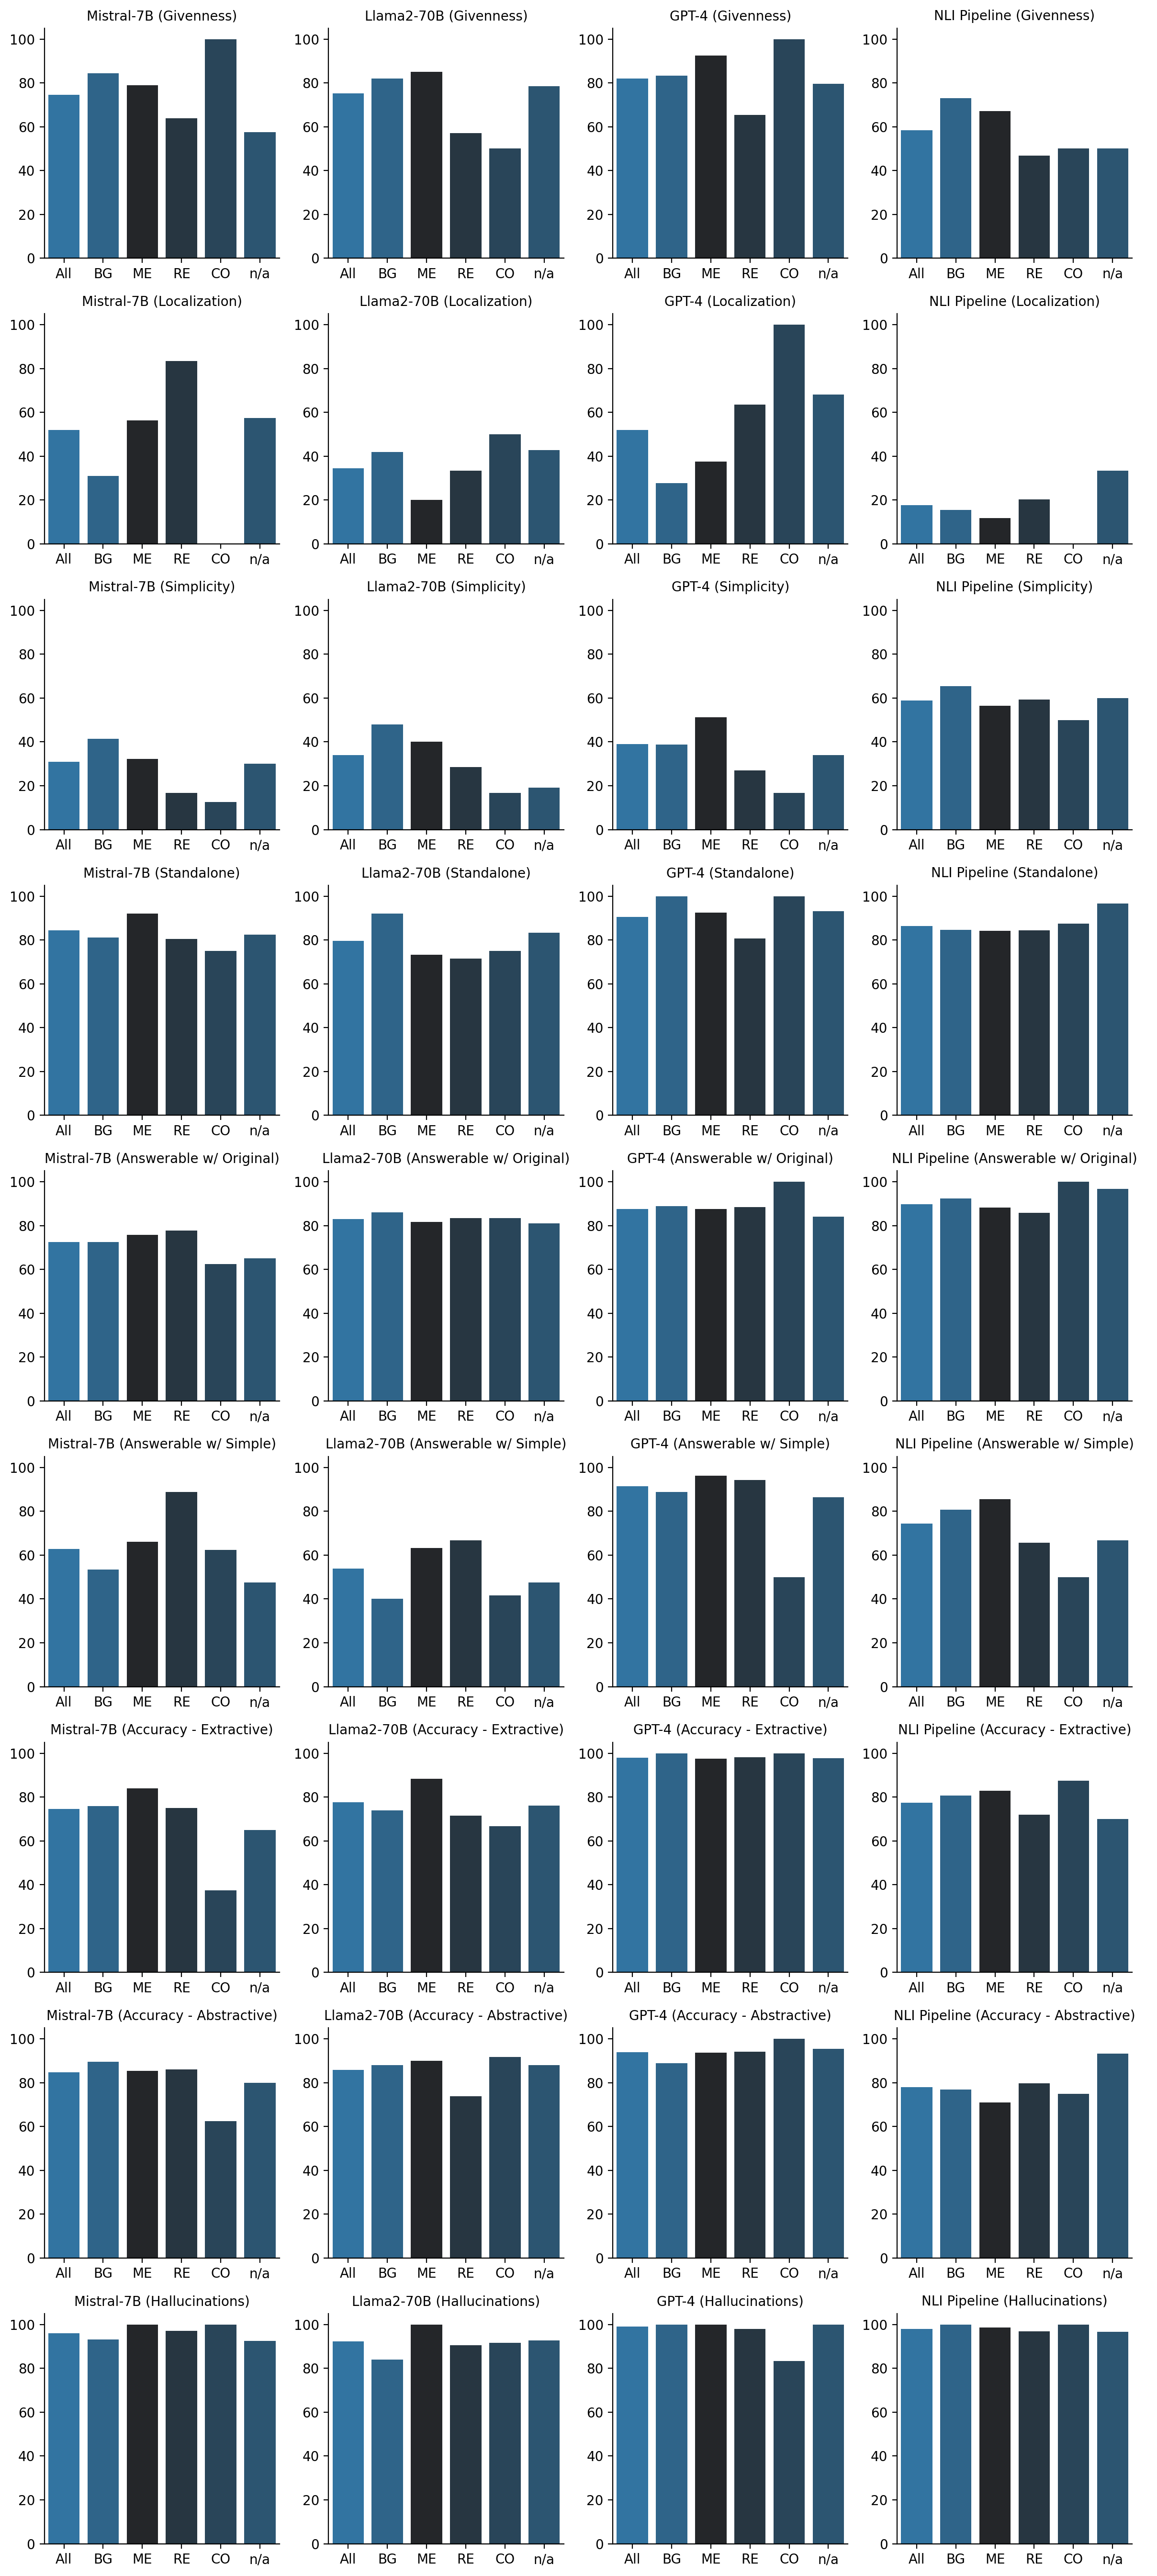

In [24]:
g = sns.FacetGrid(
    df_metrics_by_section,
    row="criterion",
    col="model",
    # gridspec_kws={"hspace":0.5}
)
g.set_titles(template="{col_name} ({row_name})")
g.map_dataframe(
    sns.barplot, x="section", y="responses", hue="section", order=order.keys()
)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel("")
    ax.set_xlabel("")
g.fig.tight_layout()
g.add_legend()
with PdfPages("figures/eval-by-section.pdf") as pdf:
    pdf.savefig(g.fig, bbox_inches="tight")